## Review: Train-Test Split and Its Limitations

### Train-Test Split Recap

Throughout this course, we have used the train-test split approach to evaluate models:

* We split the dataset into training and testing sets.
* The training set is used to fit the model.
* The testing set is used to evaluate performance on unseen data.
  
This approach provides a simple yet effective way to estimate out-of-sample performance. However, it has limitations:

### Limitations of Train-Test Split

* **High Variance**: The model’s performance depends on which specific observations end up in the training and testing sets. A different split might lead to different results.
* **Data Efficiency**: A portion of the dataset is reserved for testing, meaning the model is not trained on all available data, which can be problematic for small datasets.
* **Instability**: A single split does not always provide a robust estimate of performance, especially when data is imbalanced or noisy.

In [1]:
import numpy as np
import pandas as pd
import random
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score

from sklearn.datasets import make_classification

%matplotlib inline
plt.style.use('ggplot')
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 5, 4

In [3]:
# Generate synthetic dataset for binary classification
X, y = make_classification(n_samples=1000, n_features=10, random_state=42)

Please execute the cell below multiple times. It will be evident that the accuracy score varies with each run due to different observations in both the training and test sets.

In [4]:
# use train/test split 
X_train_class, X_test_class, y_train_class, y_test_class = train_test_split(X, y)

# Define the model
logit_model = LogisticRegression()
logit_model.fit(X_train_class, y_train_class)
y_pred = logit_model.predict(X_test_class)
print(accuracy_score(y_test_class, y_pred))

0.856


## Cross-Validation: Key Concepts

To address the limitations of train-test split, we introduce cross-validation, which provides a more reliable estimate of model performance by using multiple train-test splits.

### Steps for K-fold cross-validation
1. Split the dataset into K **equal** partitions (or "folds").
2. Use fold 1 as the **testing set** and the union of the other folds as the **training set**.
3. Calculate **testing accuracy**.
4. Repeat steps 2 and 3 K times, using a **different fold** as the testing set each time.
5. Use the **average testing accuracy** as the estimate of out-of-sample accuracy.

Diagram of **5-fold cross-validation:**

![5-fold cross-validation](https://i0.wp.com/sqlrelease.com/wp-content/uploads/2021/07/K-fold-cross-validation-1.jpg?resize=1024%2C415&ssl=1)

In [5]:
# simulate splitting a dataset of 25 observations into 5 folds
from sklearn.model_selection import KFold
kf = KFold(n_splits=5, shuffle=False).split(range(25))

# print the contents of each training and testing set
print('{} {:^61} {}'.format('Iteration', 'Training set observations', 'Testing set observations'))
for iteration, data in enumerate(kf, start=1):
    print('{:^9} {} {:^25}'.format(iteration, data[0], str(data[1])))

Iteration                   Training set observations                   Testing set observations
    1     [ 5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]        [0 1 2 3 4]       
    2     [ 0  1  2  3  4 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]        [5 6 7 8 9]       
    3     [ 0  1  2  3  4  5  6  7  8  9 15 16 17 18 19 20 21 22 23 24]     [10 11 12 13 14]     
    4     [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 20 21 22 23 24]     [15 16 17 18 19]     
    5     [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]     [20 21 22 23 24]     


**Key takeaways**

- The dataset consists of **25 observations** (indexed from 0 to 24).  
- We use **5-fold cross-validation**, meaning the process runs for **5 iterations** (one per fold).  
- In each iteration:  
  - The dataset is split into a **training set** and a **testing set**.  
  - Each observation is included in either the training set or the testing set, **but never both simultaneously**.  
- Over the entire cross-validation process:  
  - Each observation appears in the **testing set exactly once**.  
  - Each observation is included in the **training set for (K-1) = 4 iterations**.  

This ensures that every data point contributes to both model training and evaluation, improving the robustness of performance estimates.

## Cross-Validation in Scikit-Learn

### `cross_val_score`

`cross_val_score` is a function in **Scikit-Learn** that simplifies **k-fold cross-validation** for model evaluation. It automates the process of splitting the dataset, training the model, and computing performance metrics across multiple folds.

- By default, it uses **5-fold cross-validation** (`cv=5`).
- For **classification models**, it evaluates performance using **accuracy** as the default scoring metric.
- For **regression models**, it uses **R² (coefficient of determination)** by default.
- The function returns an array of scores, one for each fold, providing a more reliable estimate of model performance than a single train-test split.

Using `cross_val_score` ensures a more robust evaluation by reducing variance and making better use of available data.


In [6]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(logit_model, X, y)

print(scores)

[0.87  0.855 0.85  0.83  0.875]


Finally, we compute the **mean performance score** across all folds to obtain a robust evaluation.

In [7]:
# get the mean score
scores.mean()

0.8560000000000001

By default, `cross_val_score` in **Scikit-Learn** performs **k-fold cross-validation** using the default cross-validator for the given estimator type.

#### Default k-fold cross-validation Settings

`cv=5` unless specified


| Model Type       | Default Cross-Validator         | Shuffling | Stratification |
|-----------------|--------------------------------|-----------|---------------|
| **Classification**  | `StratifiedKFold(n_splits=5)` | ❌ No  | ✅ Yes |
| **Regression**      | `KFold(n_splits=5)`          | ❌ No  | ❌ No |

#### How to Modify the Behavior
If you need shuffling or a different cross-validation strategy, specify a custom cross-validator.

##### Enable Shuffling

In [ ]:
# Turn on the shuffle
kf = KFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(logit_model, X, y, cv=kf, scoring='accuracy')
scores

array([0.83 , 0.875, 0.87 , 0.85 , 0.865])

##### Stratified Splitting for Classification

For classification problems, **stratified sampling** is recommended for creating the folds

- Each response class should be represented with equal proportions in each of the K folds


In [9]:
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(logit_model, X, y, cv=skf, scoring='accuracy')
scores


array([0.83 , 0.84 , 0.875, 0.89 , 0.845])

##### Use Leave-One-Out (LOO) Cross-Validation

If you don't have much data, so any split from the full set to the training and validation set is going to result in really very few observations on which you can train. Leave-on-out cross validation (`LOOCV`) that might work better for cross-validation. Say you have 16 observations. Train on 15 and validate on the other one. Repeat this until you have trained on every set of 15 with the 16th sample left out. 

In [10]:
from sklearn.model_selection import LeaveOneOut

loo = LeaveOneOut()
scores = cross_val_score(logit_model, X, y, cv=loo, scoring='accuracy')
print(len(scores))
scores[:10]

1000


array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

 **Types of Cross-Validation**

| Method                | Description                                               | Use Case                             |
|-----------------------|-----------------------------------------------------------|--------------------------------------|
| **k-Fold CV**        | Splits data into `k` folds, each used for training/testing | Most common approach (e.g., `k=5` or `k=10`) |
| **Stratified k-Fold** | Like k-Fold, but preserves class proportions              | Useful for imbalanced classification |
| **Leave-One-Out (LOO-CV)** | Uses **each sample** as a test set once               | For very small datasets |
| **Leave-P-Out (LPO-CV)** | Leaves out `p` samples for testing in each iteration | Computationally expensive |
| **Time Series CV**    | Ensures training data precedes test data (rolling windows) | Time-series forecasting problems |


#### Changing the Scoring Metric in `cross_val_score`

 we can specify a different evaluation metric using the `scoring` parameter. Scikit-Learn provides various built-in metrics, including **F1-score**, precision, recall, and more.

You can specify different metrics based on the type of model:

| Task Type        | Metric Name (for `scoring`)  | Description |
|-----------------|----------------------------|-------------|
| **Classification**  | `'accuracy'`               | Default, ratio of correct predictions |
| **Classification**  | `'precision'`, `'recall'`  | Measure of correctness for positive class |
| **Classification**  | `'f1'`, `'f1_macro'`       | Harmonic mean of precision & recall |
| **Regression**      | `'neg_mean_squared_error'` | MSE (lower is better) |
| **Regression**      | `'r2'`                      | Default, measures variance explained |

You can refer to the scikit-learn [documentation](https://scikit-learn.org/stable/modules/model_evaluation.html). If a built-in metric doesn’t fit your needs, you can define a custom scoring function 

 For classification problems, especially imbalanced datasets, **F1-score** is a better metric than accuracy as it considers both **precision and recall**. Let's use it as our metric next

In [11]:
# create a KFold object with 5 splits 
folds = KFold(n_splits = 5, shuffle = True, random_state = 100)
scores = cross_val_score(logit_model, X, y, cv=folds, scoring= "f1")
scores 

array([0.875     , 0.81632653, 0.88151659, 0.87958115, 0.85869565])

### `cross_validate` in Scikit-Learn

The `cross_validate` function provides a **more comprehensive evaluation** of a model compared to `cross_val_score`.  

Its Key Feature includes:

- Allows **multiple evaluation metrics** to be specified at once.
- Returns a **detailed dictionary** containing:
  - **Training scores** and **test scores** across different folds.
  - **Fit times** (time taken to train the model for each fold).
  - **Score times** (time taken to evaluate the model for each fold).
- Useful for:
  - **Analyzing training/testing time variability** across folds.
  - **Comparing multiple performance metrics simultaneously** to get a more complete picture of model performance.

This function is ideal when you need **deeper insights** into how your model behaves across different folds, beyond just performance scores.


In [12]:
from sklearn.model_selection import cross_validate

scores = cross_validate(logit_model, X, y, scoring="accuracy", return_train_score=True)
 
df_scores = pd.DataFrame(scores)
df_scores

,fit_time,score_time,test_score,train_score
0,0.007137,0.001002,0.870,0.86125
1,0.006532,0.000997,0.855,0.86750
2,0.004417,0.000998,0.850,0.87375
3,0.001992,0.001005,0.830,0.87000
4,0.001035,0.000000,0.875,0.85750


Let's use multiple metrics

In [13]:
# Define scoring metrics explicitly for multiclass
scoring = ['accuracy', 'recall', 'precision', 'f1', 'roc_auc']

# Perform cross-validation
scores = cross_validate(logit_model, X, y, scoring=scoring, return_train_score=True)

# Convert to DataFrame for better readability
df_scores = pd.DataFrame(scores)
df_scores


,fit_time,score_time,test_accuracy,train_accuracy,test_recall,train_recall,test_precision,train_precision,test_f1,train_f1,test_roc_auc,train_roc_auc
0,0.003802,0.000000,0.870,0.86125,0.868687,0.852500,0.868687,0.867684,0.868687,0.860025,0.941394,0.931588
1,0.004556,0.004991,0.855,0.86750,0.810000,0.862155,0.890110,0.870886,0.848168,0.866499,0.944400,0.931368
2,0.003989,0.004989,0.850,0.87375,0.840000,0.867168,0.857143,0.878173,0.848485,0.872636,0.926300,0.936212
3,0.003987,0.004063,0.830,0.87000,0.840000,0.862155,0.823529,0.875318,0.831683,0.868687,0.905200,0.940987
4,0.000000,0.011978,0.875,0.85750,0.890000,0.847118,0.864078,0.864450,0.876847,0.855696,0.940200,0.932781


### `cross_val_predict` in sklearn

`cross_val_predict` is a function in Scikit-Learn that performs cross-validation but instead of returning evaluation scores, it returns predicted values for each instance in the dataset as if they were unseen.

#### **Process:**
1. The dataset is split into **k folds**.
2. The model is trained on **k-1 folds**.
3. Predictions are made on the **remaining fold**.
4. This process repeats **until every instance has been predicted once**, ensuring that each prediction is made on unseen data.

This approach **mimics real-world predictions**, making it useful for evaluating model performance with **classification reports, confusion matrices, and ROC curves**.

In [14]:
from sklearn.model_selection import cross_val_predict

# output the predicted probabilities
y_pred_prob = cross_val_predict(logit_model, X, y, cv=5, method='predict_proba')[:,1]
print(y_pred_prob.shape)
print(y_pred_prob[:10])

(1000,)
[0.04211674 0.97024937 0.96688462 0.01087727 0.65634726 0.02306063
 0.14247751 0.92610262 0.8783967  0.2408313 ]


### Key Differences Between `cross_val_score`, `cross_validate`, and `cross_val_predict`

| Function            | Returns             | Requires `scoring`? | Supports Multiple Metrics? | Can Return Train Scores? | Purpose |
|--------------------|--------------------|----------------------|--------------------------|--------------------------|---------|
| `cross_val_score`  | Array of scores    | ❌ No (defaults to accuracy for classification) | ❌ No | ❌ No | Evaluates model performance using cross-validation |
| `cross_validate`   | Dictionary         | ✅ Yes (must specify) | ✅ Yes (`scoring={'accuracy', 'precision'}`) | ✅ Yes (`return_train_score=True`) | Provides detailed evaluation metrics, including training times |
| `cross_val_predict` | Array of predictions | ❌ No (uses `predict` or `predict_proba`) | ❌ No | ❌ No | Generates out-of-sample predictions for each instance |

### Advantages and Disadvantages of Cross-Validation  

#### Advantages:  
- **Reduces Variance**: By averaging results over multiple folds, cross-validation provides a more stable estimate of model performance.  
- **Better Use of Data**: Every observation gets a chance to be in both the training and testing sets, improving data efficiency.  
- **More Reliable Performance Metrics**: The results are less dependent on a single random split, making the evaluation more robust.  

#### Disadvantages Compared to Train-Test Split: 
- **Higher Computational Cost**: Instead of training the model once (as in a train-test split), cross-validation requires training the model **k times**, making it computationally expensive for large datasets.  
- **Potential Overfitting to Small Data**: If `k` is too large (e.g., Leave-One-Out Cross-Validation), it can lead to high variance and make the model too sensitive to small changes in data.  
- **Choosing `k`**: Typically, **`k=5` or `k=10`** is recommended as a balance between bias and variance.  

Cross-validation is **preferable** for small-to-moderate datasets where stable performance estimates are important, while a simple **train-test split** is often sufficient for large datasets when computational efficiency is a priority.   


##  Cross-Validation for Hyperparameter Tuning

Cross-validation is a powerful technique that can be used for:  

- **Model Performance Evaluation**: Provides a more reliable estimate of how well a model generalizes to unseen data. 
- **Hyperparameter Tuning**: Helps find the optimal model parameters by evaluating different configurations.   
- **Model Selection**: Compares multiple models to choose the one that performs best across different folds.  
- **Feature Selection**: Assesses the impact of different feature subsets on model performance.  

In this notebook, we focus exclusively on **Hyperparameter Tuning with Cross-Validation**.  
We demonstrate how cross-validation can be used to systematically search for the best hyperparameters, ensuring **better generalization** and **optimized model performance**.  

### Finding the optimal Degree in Polynomial Regression

#### Background: Polynomial Regression

You already know simple linear regression:

$y = \beta_0 + \beta_1 x_1$

In polynomial regression of degree $n$, we fit a curve of the form:

$y = \beta_0 + \beta_1 x_1 + \beta_2x_1^2 + \beta_3x_1^3 ... + \beta_nx_1^n$

In the experiment below, we fit polynomial models of varying degrees on simulated data to analyze their performance.  
We build a **linear regression model** and use **cross-validation** to tune the polynomial degree (`p`).  

By selecting the optimal degree, we aim to **balance the trade-off between underfitting and overfitting**, ensuring the model generalizes well to unseen data.


Specifically, we Will Cover:

- **Using `cross_val_score`** for hyperparameter tuning to evaluate model performance across folds.  
- **Using `cross_validate`** to obtain detailed metrics, including training scores and fit times.  
- **Applying `GridSearchCV`** to systematically search for the optimal polynomial degree.  


#### Finding the Optimal Degree with **cross_val_score**

##### Step 1: Let's begin by importing the required libraries.


In [15]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder

##### Step 2: Let's generate  input data 

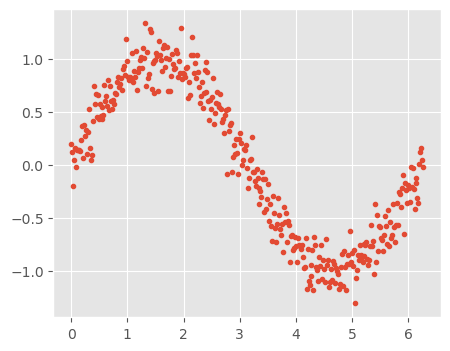

In [16]:
# Simulate input data

#Define input array with angles from 60deg to 300deg converted to radians
x = np.array([i*np.pi/180 for i in range(360)])
np.random.seed(10)  #Setting seed for reproducibility
y = np.sin(x) + np.random.normal(0,0.15,len(x))
data = pd.DataFrame(np.column_stack([x,y]),columns=['x','y'])
plt.plot(data['x'],data['y'],'.');

##### Step 3: Train-Test Split

In [17]:
# Split the data
X = data['x'].values.reshape(-1, 1)
y = data['y'].values

# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


##### Step 4:  Using `cross_val_score` to tune the *`p`* in polynomialFeatures

In sklearn, polynomial features can be generated using the `PolynomialFeatures` class. Also, to perform `LinearRegression` and `PolynomialFeatures` in tandem, we will use the module `sklearn_pipeline` - it basically creates the features and feeds the output to the model (in that sequence).

In [18]:
def cross_validation_score(X_train, y_train, max_degree=10, scoring='r2'):
    """
    Perform cross-validation for polynomial regression models with different degrees.

    Parameters:
        X_train (array-like): Training feature data.
        y_train (array-like): Training target data.
        max_degree (int): Maximum polynomial degree to evaluate.
        scoring (str): Scoring metric ('r2' for R², 'rmse' for root mean squared error).

    Returns:
        degrees (list): List of polynomial degrees evaluated.
        scores_df (DataFrame): DataFrame of cross-validation scores across different degrees.
    """
    degrees = range(1, max_degree + 1)
    cv_scores = []

    for degree in degrees:
        # Create polynomial regression model
        model = make_pipeline(
            PolynomialFeatures(degree),
            LinearRegression()
        )

        # Compute cross-validation scores
        if scoring == 'rmse':
            raw_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
            cv_score = np.sqrt(-raw_scores)  # Convert negative MSE to RMSE
            score_label = "RMSE (lower is better)"
        else:  # Default to R²
            cv_score = cross_val_score(model, X_train, y_train, cv=5, scoring='r2')
            score_label = "R² (higher is better)"

        cv_scores.append(cv_score)

    # Convert scores to a DataFrame
    scores_df = pd.DataFrame(np.array(cv_scores), index=degrees, columns=[f'Fold {i+1}' for i in range(cv_scores[0].shape[0])])
    
    print(f"Cross-validation scores ({score_label}):")
    return degrees, scores_df


In [19]:
# Example Usage:
scoring_metric = 'rmse'  # Change to 'r2' if needed
degrees, scores = cross_validation_score(X_train, y_train, scoring="rmse")

# Print the formatted score matrix
print(scores)

Cross-validation scores (RMSE (lower is better)):
      Fold 1    Fold 2    Fold 3    Fold 4    Fold 5
1   0.500794  0.456810  0.472232  0.484231  0.461889
2   0.500255  0.455897  0.475378  0.485450  0.461456
3   0.164968  0.158555  0.156423  0.152829  0.161931
4   0.165521  0.158619  0.156413  0.153359  0.162379
5   0.145887  0.138576  0.143649  0.141445  0.152968
6   0.145995  0.139056  0.143390  0.144567  0.153870
7   0.151113  0.138186  0.144122  0.144211  0.153438
8   0.150406  0.137350  0.143297  0.146944  0.154557
9   0.151095  0.138084  0.143219  0.146828  0.154599
10  0.152122  0.139420  0.145089  0.147192  0.154581


In [20]:
# take mean of each row and add it as the last column of the scores dataframe
scores['mean'] = scores.mean(axis=1)
print(scores)

      Fold 1    Fold 2    Fold 3    Fold 4    Fold 5      mean
1   0.500794  0.456810  0.472232  0.484231  0.461889  0.475191
2   0.500255  0.455897  0.475378  0.485450  0.461456  0.475687
3   0.164968  0.158555  0.156423  0.152829  0.161931  0.158941
4   0.165521  0.158619  0.156413  0.153359  0.162379  0.159258
5   0.145887  0.138576  0.143649  0.141445  0.152968  0.144505
6   0.145995  0.139056  0.143390  0.144567  0.153870  0.145376
7   0.151113  0.138186  0.144122  0.144211  0.153438  0.146214
8   0.150406  0.137350  0.143297  0.146944  0.154557  0.146511
9   0.151095  0.138084  0.143219  0.146828  0.154599  0.146765
10  0.152122  0.139420  0.145089  0.147192  0.154581  0.147681


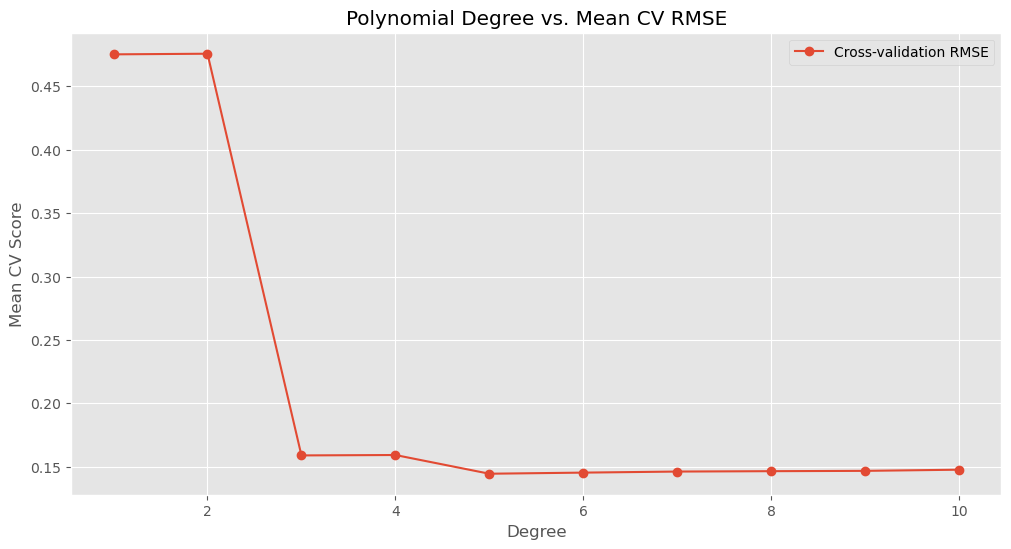

In [21]:
# plot the mean scores for each degree
plt.figure(figsize=(12, 6))
plt.plot(degrees, scores['mean'], 'o-', label='Cross-validation RMSE')
plt.xlabel('Degree')
plt.ylabel('Mean CV Score')
plt.title('Polynomial Degree vs. Mean CV RMSE')
plt.grid(True)
plt.legend();

In [22]:
# Find optimal degree based on the mean cross-validation scores
optimal_degree = scores['mean'].idxmin()
print(f'Optimal polynomial degree: {optimal_degree}')

Optimal polynomial degree: 5


In [23]:
# use r2 as performance metric, note that r2 is default metric in the function defination
degrees, scores = cross_validation_score(X_train, y_train)

# Print the formatted score matrix
print(scores)

Cross-validation scores (R² (higher is better)):
      Fold 1    Fold 2    Fold 3    Fold 4    Fold 5
1   0.474906  0.587650  0.567349  0.584471  0.590389
2   0.476036  0.589297  0.561564  0.582378  0.591156
3   0.943020  0.950323  0.952529  0.958609  0.949655
4   0.942638  0.950283  0.952535  0.958321  0.949376
5   0.955439  0.962054  0.959965  0.964546  0.955074
6   0.955373  0.961790  0.960110  0.962963  0.954543
7   0.952190  0.962267  0.959701  0.963145  0.954797
8   0.952636  0.962722  0.960162  0.961735  0.954136
9   0.952201  0.962322  0.960205  0.961795  0.954111
10  0.951549  0.961590  0.959159  0.961606  0.954121


In [24]:
# take mean of each row and add it as the last column of the scores dataframe
scores['mean'] = scores.mean(axis=1)
print(scores)


      Fold 1    Fold 2    Fold 3    Fold 4    Fold 5      mean
1   0.474906  0.587650  0.567349  0.584471  0.590389  0.560953
2   0.476036  0.589297  0.561564  0.582378  0.591156  0.560086
3   0.943020  0.950323  0.952529  0.958609  0.949655  0.950827
4   0.942638  0.950283  0.952535  0.958321  0.949376  0.950631
5   0.955439  0.962054  0.959965  0.964546  0.955074  0.959416
6   0.955373  0.961790  0.960110  0.962963  0.954543  0.958956
7   0.952190  0.962267  0.959701  0.963145  0.954797  0.958420
8   0.952636  0.962722  0.960162  0.961735  0.954136  0.958278
9   0.952201  0.962322  0.960205  0.961795  0.954111  0.958127
10  0.951549  0.961590  0.959159  0.961606  0.954121  0.957605


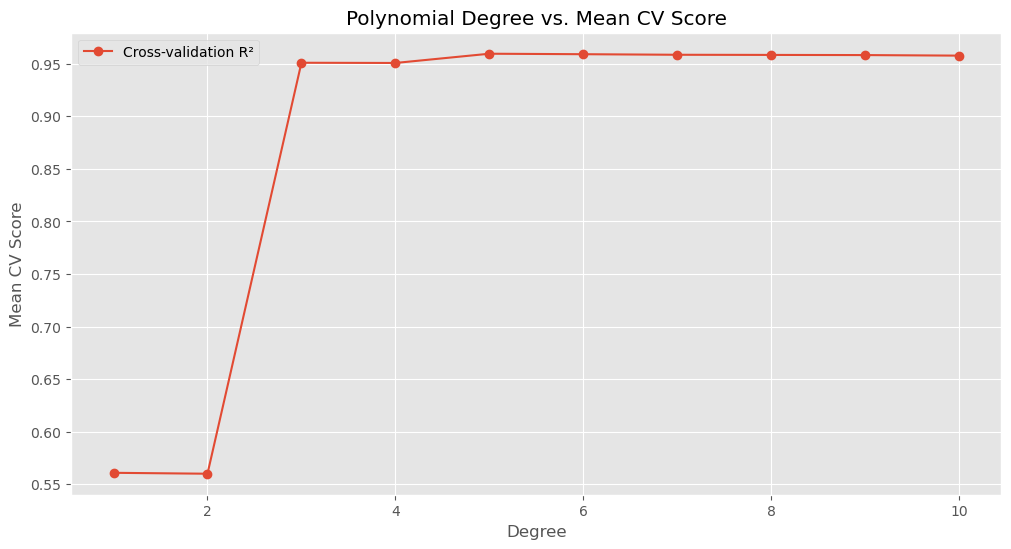

In [25]:
# plot the mean scores for each degree
plt.figure(figsize=(12, 6))
plt.plot(degrees, scores['mean'], 'o-', label='Cross-validation R²')
plt.xlabel('Degree')
plt.ylabel('Mean CV Score')
plt.title('Polynomial Degree vs. Mean CV Score')
plt.grid(True)
plt.legend();

In [26]:
# Find optimal degree based on the mean cross-validation scores
optimal_degree = scores['mean'].idxmax()
print(f'Optimal polynomial degree: {optimal_degree}')

Optimal polynomial degree: 5


##### Step 5: Fitting the Final Model with the Optimal Polynomial Degree 

After determining the **optimal polynomial degree (`p=5`)** using cross-validation, we now **refit the model** on the entire training dataset.  
This ensures that the model fully utilizes all available training data for the best possible fit.  

**Steps:**
1. **Build the final model** using a polynomial transformation with the optimal degree (`p=5`).
2. **Train the model** on the full training dataset.
3. **Generate predictions** and visualize how well the polynomial regression fits the data.

The plot below shows the **final polynomial regression fit**, highlighting how the model captures patterns in the dataset.


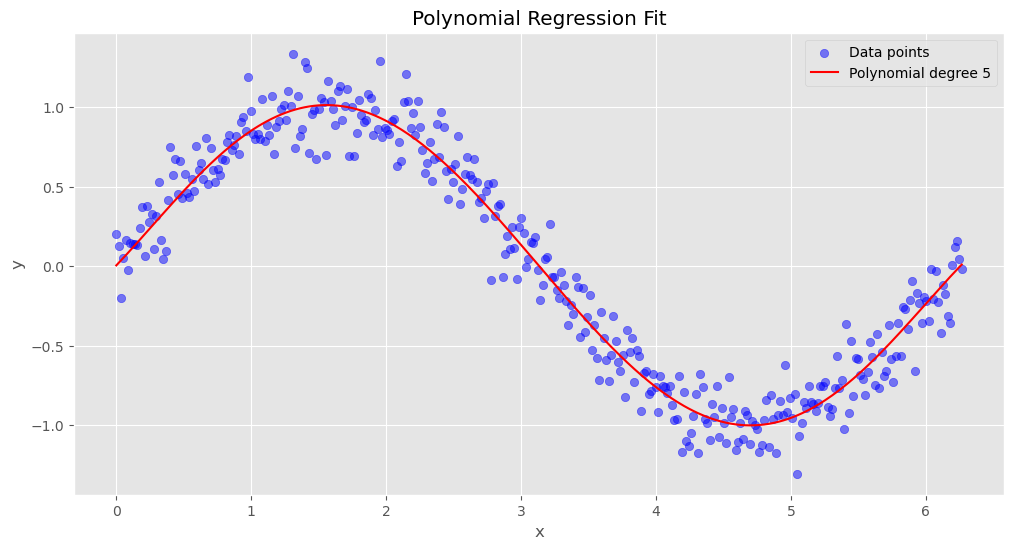

In [27]:
# Fit final model with optimal degree
final_model = make_pipeline(
    PolynomialFeatures(optimal_degree),
    LinearRegression()
)
final_model.fit(X_train, y_train)

# Plot final model predictions
plt.figure(figsize=(12, 6))
X_sorted = np.sort(X)
y_pred = final_model.predict(X_sorted)

plt.scatter(X, y, color='blue', alpha=0.5, label='Data points')
plt.plot(X_sorted, y_pred, color='red', label=f'Polynomial degree {optimal_degree}')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Polynomial Regression Fit')
plt.legend()
plt.grid(True)
plt.show()

##### Step 6: Output the final model performance

In [28]:
# Print final model performance metrics
print("\nFinal Model Performance:")
print(f"Training R²: {final_model.score(X_train, y_train):.4f}")
print(f"Test R²: {final_model.score(X_test, y_test):.4f}")


Final Model Performance:
Training R²: 0.9613
Test R²: 0.9521


#### Hyperparameter Tuning with **cross_validate**

The `cross_validate` function differs from cross_val_score in two ways:

* It allows specifying multiple metrics for evaluation.

* It returns a dict containing fit-times, score-times (and optionally training scores, fitted estimators, train-test split indices) in addition to the test score.

In [ ]:
from sklearn.model_selection import cross_validate

def cross_validation_full_results(X_train, y_train, max_degree=10):
    """
    Perform cross-validation for polynomial regression models with different degrees.
    Captures all cross-validation results including R², RMSE, fit time, score time, etc.

    Parameters:
        X_train (array-like): Training feature data.
        y_train (array-like): Training target data.
        max_degree (int): Maximum polynomial degree to evaluate.

    Returns:
        full_results_df (DataFrame): DataFrame containing all cross-validation metrics for each degree.
    """
    degrees = []
    results_dict = {
        "Fold": [],
        "Fit Time": [],
        "Score Time": [],
        "R²": [],
        "RMSE": []
    }

    for degree in range(1, max_degree + 1):
        # Create polynomial regression model
        model = make_pipeline(
            PolynomialFeatures(degree),
            LinearRegression()
        )

        # Perform cross-validation for both R² and RMSE, capturing additional metrics
        cv_results = cross_validate(model, X_train, y_train, cv=5, 
                                    scoring=['r2', 'neg_root_mean_squared_error'], return_train_score=True)
        
        # Store each fold's results separately
        for fold in range(5):  # 5 folds
            degrees.append(degree)
            results_dict["Fold"].append(fold + 1)
            results_dict["Fit Time"].append(cv_results["fit_time"][fold])
            results_dict["Score Time"].append(cv_results["score_time"][fold])
            results_dict["R²"].append(cv_results["test_r2"][fold])
            results_dict["RMSE"].append(-cv_results["test_neg_root_mean_squared_error"][fold])  # Convert negative RMSE to positive

    # Convert to DataFrame
    full_results_df = pd.DataFrame(results_dict)
    full_results_df.insert(0, "Degree", degrees)  # Add Degree column at the front

    print("Complete Cross-Validation Results (Higher R² is better, Lower RMSE is better, Fit Time & Score Time included):")
    return full_results_df

scores_df = cross_validation_full_results(X_train, y_train, max_degree=10)

scores_df

Complete Cross-Validation Results (Higher R² is better, Lower RMSE is better, Fit Time & Score Time included):


,Degree,Fold,Fit Time,Score Time,R²,RMSE
0,1,1,0.001993,0.002523,0.474906,0.500794
1,1,2,0.001994,0.002033,0.587650,0.456810
2,1,3,0.000000,0.000000,0.567349,0.472232
3,1,4,0.000996,0.000996,0.584471,0.484231
4,1,5,0.000997,0.001993,0.590389,0.461889
5,2,1,0.001482,0.000000,0.476036,0.500255
6,2,2,0.006236,0.002004,0.589297,0.455897
7,2,3,0.000996,0.000997,0.561564,0.475378
8,2,4,0.000997,0.000997,0.582378,0.485450
9,2,5,0.000997,0.000997,0.591156,0.461456


In [30]:
mean_results_df = scores_df.groupby("Degree")[["R²", "RMSE"]].mean().reset_index()
mean_results_df

,Degree,R²,RMSE
0,1,0.560953,0.475191
1,2,0.560086,0.475687
2,3,0.950827,0.158941
3,4,0.950631,0.159258
4,5,0.959416,0.144505
5,6,0.958956,0.145376
6,7,0.958420,0.146214
7,8,0.958278,0.146511
8,9,0.958127,0.146765
9,10,0.957605,0.147681


#### Grid Search Cross-Validation for Hyperparameter Tuning

A common use of **cross-validation** is tuning the hyperparameters of a model. One of the most widely used techniques for this is **grid search cross-validation**.

How Grid Search Cross-Validation Works

1. **Define a Grid of Hyperparameters:**  
   We specify a set of hyperparameters and the possible values we want to evaluate for each.
2. **Evaluate All Combinations:**  
   Every possible combination of hyperparameter values in the grid is systematically tested.
3. **Cross-Validation for Model Evaluation:**  
   For each combination, the model is trained and evaluated using cross-validation to assess performance.
4. **Select the Best Hyperparameter Setting:**  
   The combination that yields the best validation performance is chosen as the optimal set of hyperparameters.

Grid search ensures that we explore multiple hyperparameter settings in a structured way, improving the model’s performance without manually adjusting parameters.

In [31]:
from sklearn.model_selection import GridSearchCV

# Define the pipeline
model = make_pipeline(PolynomialFeatures(), LinearRegression())

# Define the hyperparameter grid
param_grid = {'polynomialfeatures__degree': np.arange(1, 11)}

# define a KFold cross-validation with shuffling
cv = KFold(n_splits=5, shuffle=True, random_state=42)


# Perform Grid Search with Cross-Validation
grid_search = GridSearchCV(model, param_grid, cv=cv, scoring= 'r2', return_train_score=True, verbose=1, n_jobs=-1)

# Fit the model
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('polynomialfeatures',
                                        PolynomialFeatures()),
                                       ('linearregression',
                                        LinearRegression())]),
             n_jobs=-1,
             param_grid={'polynomialfeatures__degree': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10])},
             return_train_score=True, scoring='r2', verbose=1)

In [32]:
cv_results = pd.DataFrame(grid_search.cv_results_)
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_polynomialfeatures__degree,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.014676,0.001534,0.002452,0.000697,1,{'polynomialfeatures__degree': 1},0.514869,0.594851,0.583781,0.548702,...,0.543991,0.043422,9,0.580311,0.549217,0.565220,0.567494,0.584039,0.569256,0.012343
1,0.014464,0.001952,0.002246,0.000386,2,{'polynomialfeatures__degree': 2},0.516412,0.596158,0.585003,0.539017,...,0.543109,0.043391,10,0.580415,0.549575,0.565611,0.569567,0.584617,0.569957,0.012318
2,0.010744,0.001704,0.001196,0.000399,3,{'polynomialfeatures__degree': 3},0.948330,0.954229,0.939908,0.950587,...,0.948949,0.004903,7,0.952702,0.950599,0.955068,0.951851,0.951932,0.952430,0.001481
3,0.003352,0.001858,0.001900,0.000197,4,{'polynomialfeatures__degree': 4},0.948137,0.954200,0.938938,0.950252,...,0.948634,0.005233,8,0.952718,0.950600,0.955190,0.951892,0.951934,0.952467,0.001522
4,0.003586,0.002212,0.001844,0.000487,5,{'polynomialfeatures__degree': 5},0.957618,0.965540,0.945282,0.960822,...,0.958620,0.007195,1,0.961771,0.959014,0.965001,0.960735,0.960368,0.961378,0.002015
5,0.002876,0.001588,0.001994,0.000631,6,{'polynomialfeatures__degree': 6},0.957569,0.965655,0.943992,0.960471,...,0.958278,0.007659,2,0.961771,0.959019,0.965278,0.960858,0.960459,0.961477,0.002097
6,0.003966,0.003833,0.001792,0.000374,7,{'polynomialfeatures__degree': 7},0.957219,0.965979,0.944374,0.960850,...,0.958136,0.007431,3,0.962026,0.959143,0.965312,0.960954,0.960862,0.961659,0.002046
7,0.002766,0.000773,0.001784,0.000394,8,{'polynomialfeatures__degree': 8},0.957222,0.966218,0.944548,0.960278,...,0.957822,0.007242,4,0.962026,0.959278,0.965478,0.961240,0.961259,0.961856,0.002026
8,0.002394,0.000487,0.001599,0.000487,9,{'polynomialfeatures__degree': 9},0.955364,0.965595,0.944424,0.960261,...,0.957306,0.007211,5,0.962294,0.959391,0.965482,0.961240,0.961259,0.961933,0.002006
9,0.002936,0.000066,0.001993,0.000036,10,{'polynomialfeatures__degree': 10},0.955130,0.965594,0.944371,0.959727,...,0.957090,0.007175,6,0.962307,0.959391,0.965501,0.961302,0.961271,0.961955,0.002008


In [33]:
pd.set_option('display.float_format', '{:.6f}'.format) 
cv_results[["mean_test_score", "mean_train_score"]]

,mean_test_score,mean_train_score
0,0.543991,0.569256
1,0.543109,0.569957
2,0.948949,0.952430
3,0.948634,0.952467
4,0.958620,0.961378
5,0.958278,0.961477
6,0.958136,0.961659
7,0.957822,0.961856
8,0.957306,0.961933
9,0.957090,0.961955


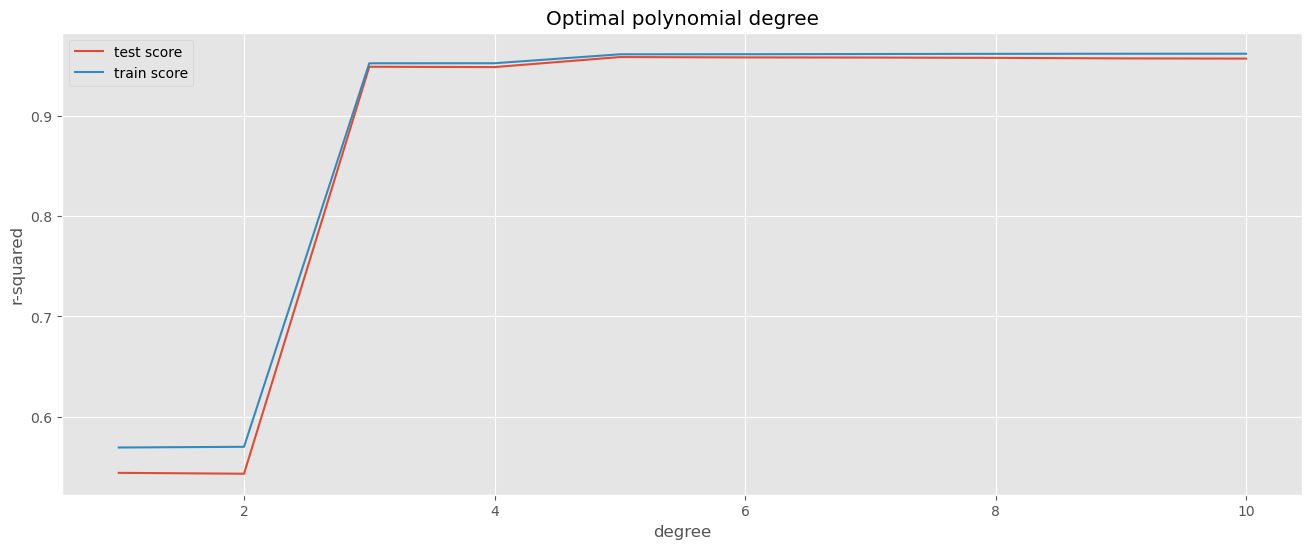

In [34]:
# plotting cv results
plt.figure(figsize=(16,6))

plt.plot(cv_results["param_polynomialfeatures__degree"], cv_results["mean_test_score"])
plt.plot(cv_results["param_polynomialfeatures__degree"], cv_results["mean_train_score"])
plt.xlabel('degree')
plt.ylabel('r-squared')
plt.title("Optimal polynomial degree")
plt.legend(['test score', 'train score'], loc='upper left');

In [35]:
# print out the best hyperparameters and the best score
print(grid_search.best_params_)
print(grid_search.best_score_)
print(grid_search.best_estimator_)

{'polynomialfeatures__degree': 5}
0.9586200484884486
Pipeline(steps=[('polynomialfeatures', PolynomialFeatures(degree=5)),
                ('linearregression', LinearRegression())])


Benefits of `GridSearchCV`

* No need for manually writing nested `for` loops for hyperparameter tuning.  
* Allows parallel processing using **multiple CPU cores** (`n_jobs=-1`), speeding up the search.  
* `GridSearchCV` guarantees finding the best combination.

However, **GridSearchCV** performs an **exhaustive search** over all possible hyperparameter combinations, ensuring that the best parameters are found. This can be slow, especially when dealing with multiple hyperparameters.

#### GridSearchCV vs. Faster Alternatives for Hyperparameter Tuning

**Two Ways to Speed Up Hyperparameter Tuning**

1. **RandomizedSearchCV**  
   - Instead of checking every combination, it **randomly samples** a set number of hyperparameter values, significantly reducing computation time.  
   - Suitable when a rough estimate of the best hyperparameters is sufficient.  

2. **ShuffleSplit**  
   - Unlike `KFold`, which ensures each sample is used exactly once as a test set, **ShuffleSplit randomly selects train-test splits** in each iteration.  
   - Reduces redundant computations, making the process faster while maintaining good model performance.  

Both approaches can be combined with `n_jobs=-1` to leverage parallel processing for even faster results.


### Tuning the classification threshold

By default, classifiers use `0.5` as the threshold for classification. However, adjusting this threshold can improve `precision`, `recall`, or `F1-score` depending on the application. Let's use cross_val_predict to tune the Classification Threshold


#### Using `TunedThresholdClassifierCV` from sklearn ( **>= Version 1.5**)

In [36]:
from sklearn.model_selection import TunedThresholdClassifierCV

# Define cross-validation strategy
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


# Define TunedThresholdClassifierCV
tuned_clf = TunedThresholdClassifierCV(
    estimator=logit_model,
    scoring="f1",  # Optimize for F1-score
    cv=cv
)

# Fit the model
tuned_clf.fit(X_train_class, y_train_class)


# Print the best threshold and the corresponding score
print(f"Best threshold: {tuned_clf.best_threshold_:.2f}")
print(f"Best F1-score: {tuned_clf.best_score_:.4f}")

Best threshold: 0.39
Best F1-score: 0.8757


#### Using `cross_val_predict`


In [39]:
# use the knn to tune the threshold for classification, the threshold is among np.arange(0.1, 0.9, 0.1), using 5 fold cross validation for tuning the threshold
thresholds = np.arange(0.1, 0.9, 0.1)
scores = []
for threshold in thresholds:
    y_pred_class_prob = cross_val_predict(logit_model, X_train_class, y_train_class, cv=5, method='predict_proba')[:,1]
    y_pred_class = (y_pred_class_prob > threshold).astype(int)
    scores.append(accuracy_score(y_train_class, y_pred_class))
scores = pd.Series(scores, index=thresholds)

df_scores = pd.DataFrame({'threshold': thresholds, 'accuracy': scores}, )
print(df_scores.to_string(index=False))


 threshold  accuracy
  0.100000  0.716000
  0.200000  0.832000
  0.300000  0.864000
  0.400000  0.868000
  0.500000  0.865333
  0.600000  0.861333
  0.700000  0.841333
  0.800000  0.810667


In [40]:
# print out the best threshold  and the cv score for the best threshold
best_threshold = scores.idxmax()
print(best_threshold)
print(scores.loc[best_threshold])

0.4
0.868
